In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (17.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121658 files and direc

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=1d98383d39a25f0b5f1e3a2fa4e63d04a4212a808eb58606f6707614fc6dcc0e
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import pandas as pd
import pyspark
import os
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LinearSVC
%matplotlib inline

from matplotlib import pyplot as plt
plt.rc('font',family='NanumBarunGothic')
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

#1

In [6]:

import os
df_spark = spark\
        .read\
        .format('csv')\
        .options(inferschema='true', delimiter=',', encoding="cp949")\
        .load(os.path.join('/content/drive/MyDrive/kddcup.data_10_percent_corrected'))

In [11]:
import os

_fname = os.path.join(os.getcwd(),'/content/drive/MyDrive/kddcup.data_10_percent.gz')

In [12]:
_rdd = spark.sparkContext.textFile(_fname)

In [8]:
df_spark.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: integer (nullable = true)
 |-- _c5: integer (nullable = true)
 |-- _c6: integer (nullable = true)
 |-- _c7: integer (nullable = true)
 |-- _c8: integer (nullable = true)
 |-- _c9: integer (nullable = true)
 |-- _c10: integer (nullable = true)
 |-- _c11: integer (nullable = true)
 |-- _c12: integer (nullable = true)
 |-- _c13: integer (nullable = true)
 |-- _c14: integer (nullable = true)
 |-- _c15: integer (nullable = true)
 |-- _c16: integer (nullable = true)
 |-- _c17: integer (nullable = true)
 |-- _c18: integer (nullable = true)
 |-- _c19: integer (nullable = true)
 |-- _c20: integer (nullable = true)
 |-- _c21: integer (nullable = true)
 |-- _c22: integer (nullable = true)
 |-- _c23: integer (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: double (nullable = true)
 |-- _c26: double (nullable = true)
 |-- _c27: d

#2

In [23]:
col_count=len(df_spark.columns)
row_count = df_spark.count()
print("컬럼 개수 : ",col_count,"\n행 개수 :", row_count)

컬럼 개수 :  42 
행 개수 : 494021


#3

In [30]:
df_spark = df_spark.withColumn('label', when(df_spark['_c41'] == 'normal.', 0).otherwise(1))

# 결과 확인

df_spark.select(df_spark['label']==1).show(10) # attack
df_spark.select(df_spark['label']==0).show(10) # normal

+-----------+
|(label = 1)|
+-----------+
|      false|
|      false|
|      false|
|      false|
|      false|
|      false|
|      false|
|      false|
|      false|
|      false|
+-----------+
only showing top 10 rows

+-----------+
|(label = 0)|
+-----------+
|       true|
|       true|
|       true|
|       true|
|       true|
|       true|
|       true|
|       true|
|       true|
|       true|
+-----------+
only showing top 10 rows



#4

In [ ]:
df_spark = df_spark.withColumn('attackB', when(df_spark['label'] == 0, 'noraml').otherwise('attack'))

In [53]:

df_spark = df_spark.withColumn('__c1', when(df_spark['_c1'] == 'tcp', 'tcp')\
                                .when(df_spark['_c1'] == 'udp', 'udp')\
                                .when(df_spark['_c1'] == 'icmp', None))

dd=df_spark.drop(df_spark['_c1']=='icmp')

In [55]:
dd.groupBy('_c1').pivot('attackB').avg('_c5').show()

+----+-------------------+-----------------+
| _c1|             attack|           noraml|
+----+-------------------+-----------------+
| tcp|  881.4052467064599| 4263.96793511515|
| udp|0.22939677145284623|89.89471763049487|
|icmp|                0.0|              0.0|
+----+-------------------+-----------------+



#5

In [56]:
df_spark.groupBy('_c1').pivot('attackB').count().show()

+----+------+------+
| _c1|attack|noraml|
+----+------+------+
| tcp|113252| 76813|
| udp|  1177| 19177|
|icmp|282314|  1288|
+----+------+------+



#6

TypeError: ignored

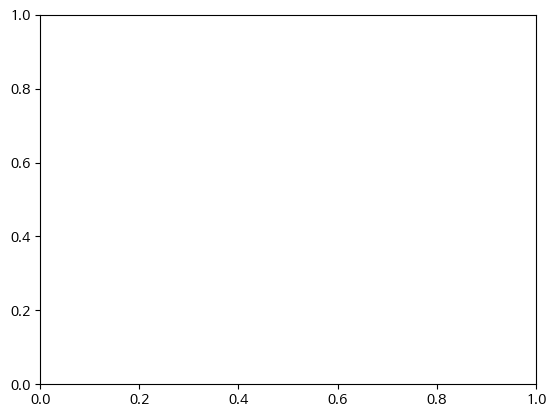

In [81]:

X=df_spark.select('attackB')
Y=df_spark.select('_c1').rdd.flatMap(lambda x:x).count()

plt.bar(X,Y)

#7

In [65]:
from pyspark.ml.feature import StringIndexer

labelIndexer = StringIndexer(inputCol="_c1", outputCol="_C11")
model=labelIndexer.fit(df_spark)
_df_spark=model.transform(df_spark)

In [66]:
featureIndexer = StringIndexer(inputCol="attackB", outputCol="__attackB")
model=featureIndexer.fit(_df_spark)
_df_spark=model.transform(_df_spark)

In [67]:
from pyspark.ml.feature import VectorAssembler

va = VectorAssembler(inputCols=["__attackB"], outputCol="__attackB_Va")
_df_spark = va.transform(_df_spark)

In [68]:
from pyspark.ml.stat import ChiSquareTest
r = ChiSquareTest.test(_df_spark, "__attackB_Va", "_C11")

In [69]:
r.show()

+-------+----------------+--------------------+
|pValues|degreesOfFreedom|          statistics|
+-------+----------------+--------------------+
|  [0.0]|             [2]|[189469.40558178938]|
+-------+----------------+--------------------+



p-value 값이 0인걸봐서 임계치인 0.05값보다 작으므로 두 속성간의 연관이 없다는 귀무가설은 기각된다고 추론할 수 있다.


#8


In [70]:
df_spark.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: integer (nullable = true)
 |-- _c5: integer (nullable = true)
 |-- _c6: integer (nullable = true)
 |-- _c7: integer (nullable = true)
 |-- _c8: integer (nullable = true)
 |-- _c9: integer (nullable = true)
 |-- _c10: integer (nullable = true)
 |-- _c11: integer (nullable = true)
 |-- _c12: integer (nullable = true)
 |-- _c13: integer (nullable = true)
 |-- _c14: integer (nullable = true)
 |-- _c15: integer (nullable = true)
 |-- _c16: integer (nullable = true)
 |-- _c17: integer (nullable = true)
 |-- _c18: integer (nullable = true)
 |-- _c19: integer (nullable = true)
 |-- _c20: integer (nullable = true)
 |-- _c21: integer (nullable = true)
 |-- _c22: integer (nullable = true)
 |-- _c23: integer (nullable = true)
 |-- _c24: double (nullable = true)
 |-- _c25: double (nullable = true)
 |-- _c26: double (nullable = true)
 |-- _c27: d

In [71]:
ve = VectorAssembler(inputCols=["_c4",'_c5','_c7','_c8','_c9','_c10','_c11','_c12','_c13','_c14','_c15','_c16','_c17','_c18','_c19','_c20','_c21','_c22','_c23','_c24','_c25','_c26','_c27','_c28','_c29','_c30','_c31','_c32','_c33','_c34','_c35','_c36','_c37','_c38','_c39','_c40'], outputCol="features")
df_spark = ve.transform(df_spark)

In [72]:
df_spark.select(df_spark['label'], df_spark['features']).show(10)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|(36,[0,1,6,17,18,...|
|    0|(36,[0,1,6,17,18,...|
|    0|(36,[0,1,6,17,18,...|
|    0|(36,[0,1,6,17,18,...|
|    0|(36,[0,1,6,17,18,...|
|    0|(36,[0,1,6,17,18,...|
|    0|(36,[0,1,6,17,18,...|
|    0|(36,[0,1,6,17,18,...|
|    0|(36,[0,1,6,17,18,...|
|    0|(36,[0,1,4,6,17,1...|
+-----+--------------------+
only showing top 10 rows



#9

In [75]:
train, test = df_spark.randomSplit([0.6,0.4])
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=10, regParam=0.1)

In [76]:
lsvcModel = lsvc.fit(train)
print("Coefficients: " + str(lsvcModel.coefficients))
print("Intercept: " + str(lsvcModel.intercept))

testDf = lsvcModel.transform(test)

Coefficients: [3.540976972105841e-09,4.769824986186126e-07,0.6799309946531916,2.18981592879884,0.10915737795787046,1.425508539366188,-0.15604740026363587,0.001860171769746162,2.044064478183996,-0.37156939704212166,-0.0014999419463123202,-0.028405848835144458,0.12074668306198466,-0.18969534492907805,0.0,0.0,-0.546935777134903,0.0019755010246835093,0.0012512652073642752,0.28176716157330606,0.28148275890755525,0.23549398164612512,0.25514736149114364,-0.4769426567080655,0.48801688649875036,-0.3117421498005443,0.0033012536635061065,-0.0006292836068892662,-0.15805869224872213,-1.0494702537399465,0.49033407602153584,0.29469854723494954,0.280760197019513,0.28094567899579803,0.26586314660451815,0.2912703436931371]
Intercept: -1.0503635171714336


In [77]:
testDf.select("prediction","label").show()

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
|       0.0|    1|
+----------+-----+
only showing top 20 rows



#10

In [78]:
ve = VectorAssembler(inputCols=["_c1","_c4",'_c5','_c7','_c8','_c9','_c10','_c11','_c12','_c13','_c14','_c15','_c16','_c17','_c18','_c19','_c20','_c21','_c22','_c23','_c24','_c25','_c26','_c27','_c28','_c29','_c30','_c31','_c32','_c33','_c34','_c35','_c36','_c37','_c38','_c39','_c40'], outputCol="features")
df_spark = ve.transform(df_spark)

IllegalArgumentException: ignored